In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split

In [2]:
class LaticiferDataset(Dataset):
    def __init__(self, df, root_dir, image_size=(1024, 1024), augment=False):
        self.df = df
        self.root = root_dir
        self.augment = augment
        self.image_size = image_size

        self.transforms = A.Compose([
            A.Resize(*image_size),
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.3),
            A.ElasticTransform(p=0.3),
            A.GaussianBlur(p=0.2),
            A.Normalize(),
            ToTensorV2()
        ]) if augment else A.Compose([
            A.Resize(*image_size),
            A.Normalize(),
            ToTensorV2()
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        gray_path = os.path.join(self.root, row['gray_img_path'])
        enhanced_path = os.path.join(self.root, row['enhanced_img_path'])
        mask_path = os.path.join(self.root, row['mask_path'])

        image = np.array(Image.open(enhanced_path).convert("L"))
        mask = np.array(Image.open(mask_path).convert("L")) // 255

        augmented = self.transforms(image=image, mask=mask)
        return augmented['image'], augmented['mask'].unsqueeze(0).float()

In [3]:
# U-Net Model (Lightweight)
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, 3, padding=1),
                nn.ReLU(inplace=True),
            )

        self.enc1 = conv_block(in_channels, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)

        self.pool = nn.MaxPool2d(2)

        self.bottleneck = conv_block(512, 1024)

        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = conv_block(1024, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = conv_block(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = conv_block(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = conv_block(128, 64)

        self.final = nn.Conv2d(64, out_channels, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        b = self.bottleneck(self.pool(e4))

        d4 = self.dec4(torch.cat([self.up4(b), e4], dim=1))
        d3 = self.dec3(torch.cat([self.up3(d4), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))

        return torch.sigmoid(self.final(d1))

In [4]:
# Dice Loss
def dice_loss(pred, target, smooth=1.):
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    return 1 - ((2. * intersection + smooth) / (pred.sum() + target.sum() + smooth))

In [5]:
def compute_dice(preds, targets, threshold=0.5, eps=1e-7):
    preds = (preds > threshold).float()
    intersection = (preds * targets).sum(dim=(1, 2, 3))
    union = preds.sum(dim=(1, 2, 3)) + targets.sum(dim=(1, 2, 3))
    dice = (2. * intersection + eps) / (union + eps)
    return dice.mean().item()

In [ ]:
def train_model(model, train_loader, test_loader, num_epochs=20, save_dir=None, log_interval=5):
    model = model.cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = lambda pred, target: nn.BCELoss()(pred, target) + dice_loss(pred, target)

    best_dice = 0.0
    best_val_loss = float('inf')
    best_epoch = 0
    best_model_path = None

    for epoch in tqdm(range(1, num_epochs + 1), desc="Training Epochs", leave=False, unit='epoch'):
        # --- Training ---
        model.train()
        train_loss = 0
        for images, masks in train_loader:
            images, masks = images.cuda(), masks.cuda()
            preds = model(images)

            loss = criterion(preds, masks)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        #print(f"🔁 Epoch {epoch}: Train Loss = {avg_train_loss:.4f}")
        
        # --- Validation ---
        model.eval()
        val_loss = 0
        dice_scores = []

        with torch.no_grad():
            for images, masks in test_loader:
                images, masks = images.cuda(), masks.cuda()
                preds = model(images)

                loss = criterion(preds, masks)
                val_loss += loss.item()

                dice = compute_dice(preds, masks)
                dice_scores.append(dice)

        avg_val_loss = val_loss / len(test_loader)
        avg_dice = np.mean(dice_scores)
        #print(f"✅ Epoch {epoch}: Val Loss = {avg_val_loss:.4f} | Dice = {avg_dice:.4f}")

        # --- Save best model ---
        if avg_dice > best_dice:
            best_dice = avg_dice
            best_epoch = epoch
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            if best_model_path and os.path.exists(best_model_path):
                os.remove(best_model_path)
            if save_dir:
                os.makedirs(save_dir, exist_ok=True)
                best_model_path = os.path.join(save_dir, f"best_deeplab_{epoch}_{best_dice:.4f}.pth")
                torch.save(model.state_dict(), best_model_path)
                #print(f"New best model saved with Dice {best_dice:.4f} at {best_model_path}")
        if epoch % log_interval == 0 or epoch == num_epochs:
            print(f"Epoch {epoch:03d} | "
                  f"Train Loss: {avg_train_loss:.4f} | "
                  f"Val Loss: {avg_val_loss:.4f} | Best Dice: {best_dice:.4f}")

    print("Training completed.")
    print(f"Best Dice achieved: {best_dice}, Epoch: {best_epoch}")
    if best_model_path:
        print("Best model path:", best_model_path)

    return best_model_path, best_dice, best_val_loss

In [7]:
dataset_root = "/home/smadper/TFM/datasets/laticifers"
df = pd.read_csv(os.path.join(dataset_root, "laticifer_dataset_index.csv"))
df = df[df["is_labeled"] == True].reset_index(drop=True)
train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)

train_dataset = LaticiferDataset(train_df, dataset_root, augment=True)
test_dataset = LaticiferDataset(val_df, dataset_root, augment=False)

print(f"Total samples: {len(df)}")
print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

Total samples: 35
Training samples: 31
Test samples: 4


In [ ]:
model = UNet(in_channels=1).cuda()

best_model_path, best_dice, best_val_loss = train_model(
    model=model, 
    train_loader=train_loader, 
    test_loader=test_loader, 
    num_epochs=200,
    save_dir=dataset_root
)

Training Epochs:   2%|▎         | 5/200 [02:03<1:19:47, 24.55s/epoch]

Epoch 005 | Train Loss: 1.0975 | Val Loss: 1.0672 | Best Dice: 0.0000


Training Epochs:   5%|▌         | 10/200 [04:08<1:18:39, 24.84s/epoch]

Epoch 010 | Train Loss: 1.0555 | Val Loss: 1.0288 | Best Dice: 0.0020


Training Epochs:   8%|▊         | 15/200 [06:08<1:14:19, 24.11s/epoch]

Epoch 015 | Train Loss: 0.9814 | Val Loss: 0.9453 | Best Dice: 0.2817


Training Epochs:  10%|█         | 20/200 [08:08<1:11:51, 23.95s/epoch]

Epoch 020 | Train Loss: 0.9977 | Val Loss: 0.9430 | Best Dice: 0.2954


Training Epochs:  12%|█▎        | 25/200 [10:11<1:11:23, 24.48s/epoch]

Epoch 025 | Train Loss: 0.9533 | Val Loss: 0.9228 | Best Dice: 0.2954


Training Epochs:  15%|█▌        | 30/200 [12:15<1:10:50, 25.00s/epoch]

Epoch 030 | Train Loss: 0.9454 | Val Loss: 0.9066 | Best Dice: 0.3157


Training Epochs:  18%|█▊        | 35/200 [14:19<1:08:33, 24.93s/epoch]

Epoch 035 | Train Loss: 0.9225 | Val Loss: 0.8806 | Best Dice: 0.3373


Training Epochs:  20%|██        | 40/200 [16:23<1:05:57, 24.74s/epoch]

Epoch 040 | Train Loss: 0.9157 | Val Loss: 0.8760 | Best Dice: 0.3402


Training Epochs:  22%|██▎       | 45/200 [18:26<1:03:02, 24.40s/epoch]

Epoch 045 | Train Loss: 0.8944 | Val Loss: 0.8494 | Best Dice: 0.3640


Training Epochs:  25%|██▌       | 50/200 [20:26<1:00:09, 24.06s/epoch]

Epoch 050 | Train Loss: 0.8750 | Val Loss: 0.8315 | Best Dice: 0.3712


Training Epochs:  28%|██▊       | 55/200 [22:29<59:55, 24.80s/epoch]  

Epoch 055 | Train Loss: 0.8514 | Val Loss: 0.8173 | Best Dice: 0.3917


Training Epochs:  30%|███       | 60/200 [24:29<56:36, 24.26s/epoch]

Epoch 060 | Train Loss: 0.8220 | Val Loss: 0.7916 | Best Dice: 0.4029


Training Epochs:  32%|███▎      | 65/200 [26:32<55:18, 24.58s/epoch]

Epoch 065 | Train Loss: 0.8155 | Val Loss: 0.7780 | Best Dice: 0.4201


Training Epochs:  35%|███▌      | 70/200 [28:33<52:25, 24.19s/epoch]

Epoch 070 | Train Loss: 0.7910 | Val Loss: 0.7740 | Best Dice: 0.4206


Training Epochs:  38%|███▊      | 75/200 [30:34<50:14, 24.12s/epoch]

Epoch 075 | Train Loss: 0.7825 | Val Loss: 0.7570 | Best Dice: 0.4293


Training Epochs:  40%|████      | 80/200 [32:34<48:13, 24.12s/epoch]

Epoch 080 | Train Loss: 0.7610 | Val Loss: 0.7611 | Best Dice: 0.4383


Training Epochs:  42%|████▎     | 85/200 [34:37<46:53, 24.47s/epoch]

Epoch 085 | Train Loss: 0.7580 | Val Loss: 0.7539 | Best Dice: 0.4395


Training Epochs:  45%|████▌     | 90/200 [36:42<45:49, 24.99s/epoch]

Epoch 090 | Train Loss: 0.7477 | Val Loss: 0.7653 | Best Dice: 0.4462


Training Epochs:  48%|████▊     | 95/200 [38:46<43:35, 24.91s/epoch]

Epoch 095 | Train Loss: 0.7286 | Val Loss: 0.7456 | Best Dice: 0.4465


Training Epochs:  50%|█████     | 100/200 [40:46<40:16, 24.16s/epoch]

Epoch 100 | Train Loss: 0.7282 | Val Loss: 0.7543 | Best Dice: 0.4506


Training Epochs:  52%|█████▎    | 105/200 [42:46<38:09, 24.10s/epoch]

Epoch 105 | Train Loss: 0.7103 | Val Loss: 0.7491 | Best Dice: 0.4506


Training Epochs:  55%|█████▌    | 110/200 [44:49<36:55, 24.62s/epoch]

Epoch 110 | Train Loss: 0.6983 | Val Loss: 0.7530 | Best Dice: 0.4506


Training Epochs:  57%|█████▊    | 115/200 [46:50<34:35, 24.42s/epoch]

Epoch 115 | Train Loss: 0.6909 | Val Loss: 0.7535 | Best Dice: 0.4506


Training Epochs:  60%|██████    | 120/200 [48:54<32:53, 24.67s/epoch]

Epoch 120 | Train Loss: 0.6400 | Val Loss: 0.7586 | Best Dice: 0.4506


Training Epochs:  62%|██████▎   | 125/200 [50:52<29:39, 23.73s/epoch]

Epoch 125 | Train Loss: 0.6157 | Val Loss: 0.7781 | Best Dice: 0.4506


Training Epochs:  65%|██████▌   | 130/200 [52:55<28:35, 24.50s/epoch]

Epoch 130 | Train Loss: 0.5739 | Val Loss: 0.7914 | Best Dice: 0.4506


Training Epochs:  68%|██████▊   | 135/200 [54:56<26:25, 24.39s/epoch]

Epoch 135 | Train Loss: 0.5176 | Val Loss: 0.8138 | Best Dice: 0.4506


Training Epochs:  70%|███████   | 140/200 [56:58<24:27, 24.46s/epoch]

Epoch 140 | Train Loss: 0.4992 | Val Loss: 0.8294 | Best Dice: 0.4506


Training Epochs:  72%|███████▎  | 145/200 [59:02<22:50, 24.91s/epoch]

Epoch 145 | Train Loss: 0.4497 | Val Loss: 0.8251 | Best Dice: 0.4506


Training Epochs:  75%|███████▌  | 150/200 [1:01:04<20:17, 24.35s/epoch]

Epoch 150 | Train Loss: 0.4521 | Val Loss: 0.8389 | Best Dice: 0.4506


Training Epochs:  78%|███████▊  | 155/200 [1:03:11<18:46, 25.03s/epoch]

Epoch 155 | Train Loss: 0.4002 | Val Loss: 0.8503 | Best Dice: 0.4506


Training Epochs:  80%|████████  | 160/200 [1:05:14<16:30, 24.77s/epoch]

Epoch 160 | Train Loss: 0.4000 | Val Loss: 0.8575 | Best Dice: 0.4506


Training Epochs:  82%|████████▎ | 165/200 [1:07:16<14:11, 24.33s/epoch]

Epoch 165 | Train Loss: 0.3740 | Val Loss: 0.8627 | Best Dice: 0.4506


Training Epochs:  85%|████████▌ | 170/200 [1:09:18<12:07, 24.24s/epoch]

Epoch 170 | Train Loss: 0.3643 | Val Loss: 0.8677 | Best Dice: 0.4506


Training Epochs:  88%|████████▊ | 175/200 [1:11:18<10:00, 24.01s/epoch]

Epoch 175 | Train Loss: 0.3345 | Val Loss: 0.8749 | Best Dice: 0.4506


Training Epochs:  90%|█████████ | 180/200 [1:13:20<08:05, 24.27s/epoch]

Epoch 180 | Train Loss: 0.3280 | Val Loss: 0.8810 | Best Dice: 0.4506


Training Epochs:  92%|█████████▎| 185/200 [1:15:24<06:11, 24.76s/epoch]

Epoch 185 | Train Loss: 0.3078 | Val Loss: 0.8898 | Best Dice: 0.4506


Training Epochs:  95%|█████████▌| 190/200 [1:17:29<04:08, 24.90s/epoch]

Epoch 190 | Train Loss: 0.2951 | Val Loss: 0.8969 | Best Dice: 0.4506


Training Epochs:  98%|█████████▊| 195/200 [1:19:35<02:05, 25.17s/epoch]

Epoch 195 | Train Loss: 0.2960 | Val Loss: 0.8837 | Best Dice: 0.4506


Epoch 200 | Train Loss: 0.2928 | Val Loss: 0.8958 | Best Dice: 0.4506
Training completed.
Best Dice achieved: 0.4506050944328308, Epoch: 97
Best model path: /home/smadper/TFM/datasets/laticifers/best_deeplab_97_0.4506.pth


In [9]:
import matplotlib.pyplot as plt

def visualize_predictions(model, test_loader, num_samples=5):
    model.eval()
    model.cuda()

    samples_shown = 0
    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.cuda(), masks.cuda()
            preds = model(images)
            preds = (preds > 0.5).float()

            for i in range(images.size(0)):
                if samples_shown >= num_samples:
                    return

                image_np = images[i].cpu().squeeze().numpy()
                mask_np = masks[i].cpu().squeeze().numpy()
                pred_np = preds[i].cpu().squeeze().numpy()

                fig, axs = plt.subplots(1, 3, figsize=(12, 4))
                axs[0].imshow(image_np, cmap='gray')
                axs[0].set_title("Input Image")
                axs[1].imshow(mask_np, cmap='gray')
                axs[1].set_title("Ground Truth Mask")
                axs[2].imshow(pred_np, cmap='gray')
                axs[2].set_title("Predicted Mask")

                for ax in axs:
                    ax.axis('off')
                plt.tight_layout()
                plt.show()

                samples_shown += 1


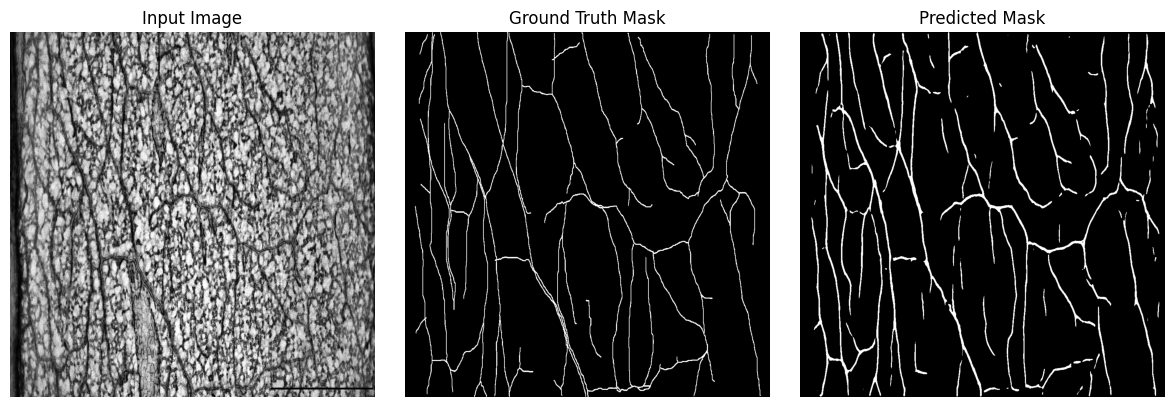

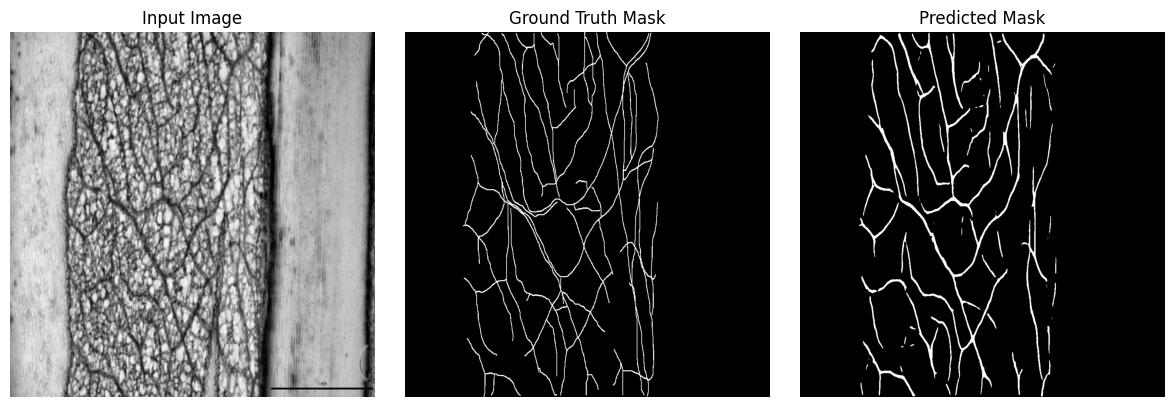

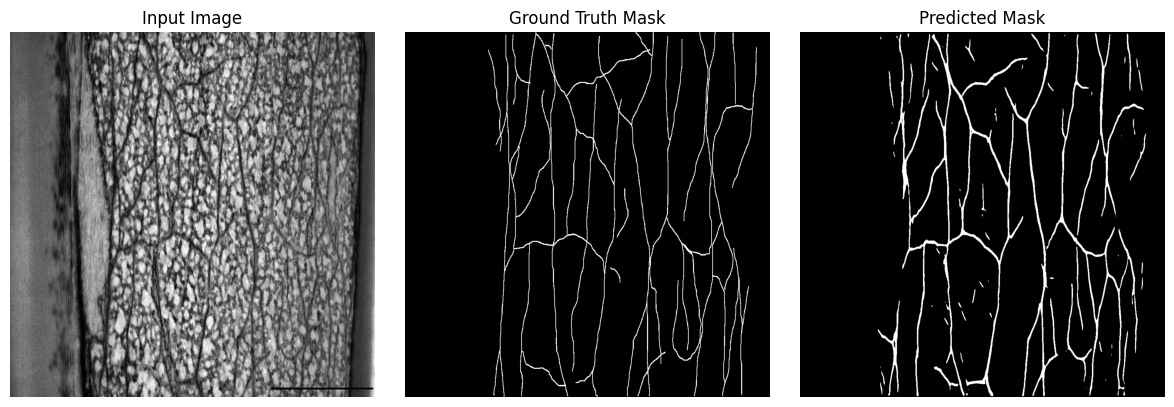

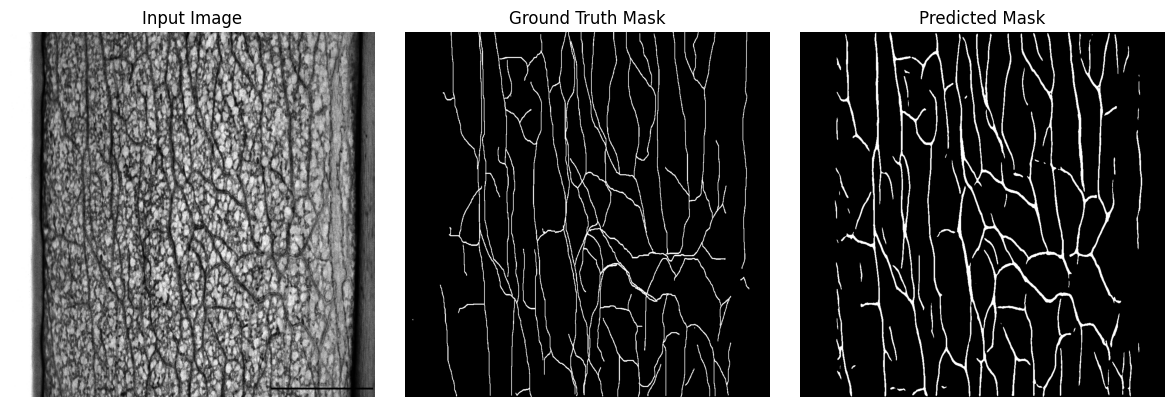

In [11]:
model.load_state_dict(torch.load("../datasets/laticifers/best_deeplab_97_0.4506.pth"))

visualize_predictions(model, test_loader, num_samples=4)